# ORENIST Dynamic Filter Classification

Note: This notebook is desinged to run with GPU runtime.

####[ODF-01]
Import modules and set random seeds.

In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models

random.seed(20230509)
np.random.seed(20190225)
tf.random.set_seed(20190225)

####[ODF-02]
Download the ORENIST dataset and store into NumPy arrays.

In [2]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0   468k      0  0:00:01  0:00:01 --:--:-- 3791k


####[ODF-03]
Define a model to classify the ORENIST dataset with the convolutional filters.

The ouputs from filters are converted to a single pixel image with the pooling layer.

In [3]:
model = models.Sequential(name='ORENIST_classification_model')
model.add(layers.Input(shape=(28*28,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same', use_bias=False,
                        name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.MaxPooling2D((28, 28), name='max_pooling'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))

model.summary()

Model: "ORENIST_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 28, 28, 2)           │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ abs (Lambda)                         │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (MaxPooling2D)           │ (None, 1, 1, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 3)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59 (236.00 B)

 Trainable params: 59 (236.00 B)

 Non-trainable params: 0 (0.00 B)

####[ODF-04]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

####[ODF-05]
Train the model.

In [5]:
%%time
images_tiled, labels_tiled = np.tile(images, (400, 1)), np.tile(labels, (400, 1))
history = model.fit(images_tiled, labels_tiled, batch_size=len(images), epochs=10)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.3361 - loss: 1.1763
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3344 - loss: 1.0936
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3805 - loss: 0.9923
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6436 - loss: 0.7511
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6170 - loss: 0.5601
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6390 - loss: 0.5106
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7727 - loss: 0.4674
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9804 - loss: 0.2878
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.9986 - loss: 0.1226
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 1.0000 - loss: 0.0671
CPU times: user 14.9 s, sys: 1.51 s, total: 16.4 s
Wall time: 16.3 s


####[ODF-07]
Define a model to extract outputs from intermediate layers.

In [7]:
layer_outputs = [model.get_layer('abs').output,
                 model.get_layer('max_pooling').output]
model2 = models.Model(inputs=model.inputs[0], outputs=layer_outputs)

####[ODF-08]
Apply the trained filters to the ORENST dataset.

In [8]:
conv_output, pool_output = model2.predict(images[:9])
filter_vals = model.get_layer('conv_filter').get_weights()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


####[ODF-09]
Show images after applying the convolutional filters.

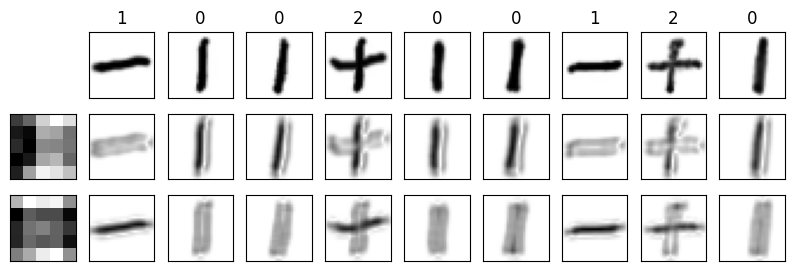

In [9]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(conv_output)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i,:,:,0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i,:,:,1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

####[ODF-10]
Show images after applying the pooling layer.

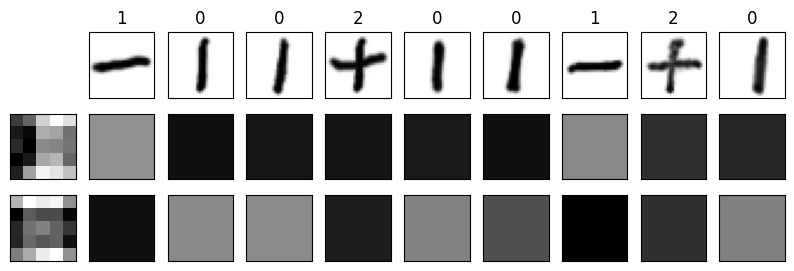

In [10]:
fig = plt.figure(figsize=(10, 3))
v_max = np.max(pool_output)


for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

####[ODF-11]
Convert outputs from the pooling layer into binary values with a threshold 8.0.



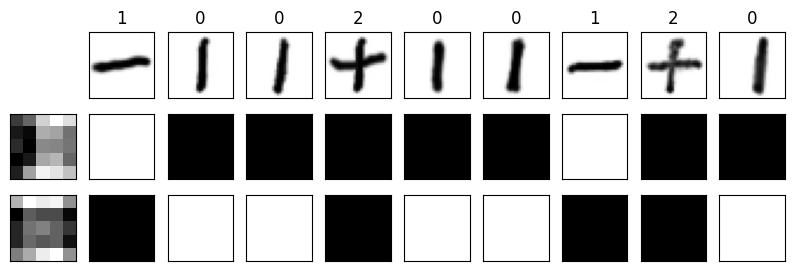

In [13]:
fig = plt.figure(figsize=(10, 3))
bin_index = np.sign(pool_output-8.0)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 0],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 1],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)